In [1]:
import pandas as pd
import numpy as np


In [2]:
df=pd.read_csv('driver_data.csv')

In [3]:
df.head(20)

,Distance_Feature,Speeding_Feature
0,71.24,28
1,52.53,25
2,64.54,27
3,55.69,22
4,54.58,25
5,41.91,10
6,58.64,20
7,52.02,8
8,31.25,34
9,44.31,19


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Distance_Feature  4000 non-null   float64
 1   Speeding_Feature  4000 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 62.6 KB


In [5]:
x=df.iloc[:,0:2].values
x.shape

(4000, 2)

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
std_scale = StandardScaler().fit(x)

In [8]:
market_data_scaled = std_scale.transform(x)

In [9]:
market_data_scaled

array([[-0.0898104 ,  1.26061251],
       [-0.43977285,  1.04174351],
       [-0.215131  ,  1.18765617],
       ...,
       [ 1.77447381,  0.09331115],
       [ 1.87229869, -0.41738319],
       [ 1.72060465, -0.12555785]])

In [10]:
from sklearn.cluster import KMeans

In [11]:
ssq = []

for K in range(1,11):
    kmeans_model = KMeans(n_clusters=K, random_state=123)
    kmeans_model.fit(market_data_scaled)
    ssq.append(kmeans_model.inertia_)

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Scree Plot')

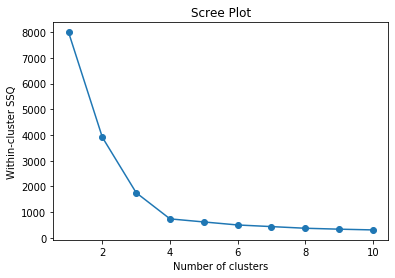

In [13]:
plt.plot(range(1,11), ssq, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Within-cluster SSQ")
plt.title("Scree Plot")

In [14]:
km=KMeans(n_clusters=4,random_state=123)
km.fit(market_data_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=123, tol=0.0001, verbose=0)

In [15]:
predicted_cluster=km.predict(market_data_scaled)

In [16]:
from scipy.spatial.distance import cdist

def plot_kmeans(km, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = plt.gca()
    ax.axis('equal')
    ax.scatter(x[:, 0], x[:, 1], c=labels, s=40, cmap='viridis',zorder=2)

    # plot the representation of the KMeans model
    centers = km.cluster_centers_
    radii = [cdist(x[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC',zorder=1))

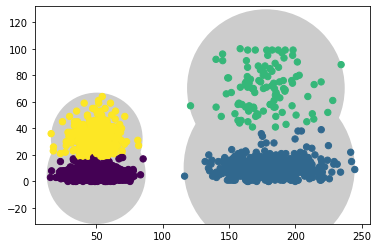

In [17]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, x)

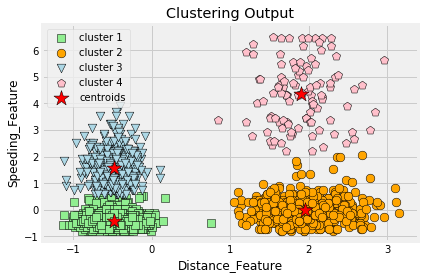

In [68]:
plt.scatter(market_data_scaled[predicted_cluster==0,0], market_data_scaled[predicted_cluster==0, 1], s=75, c='lightgreen',\
           marker='s', edgecolors='black', label='cluster 1')
plt.scatter(market_data_scaled[predicted_cluster==1,0], market_data_scaled[predicted_cluster==1, 1], s=75, c='orange',\
           marker='o', edgecolors='black', label='cluster 2')
plt.scatter(market_data_scaled[predicted_cluster==2,0], market_data_scaled[predicted_cluster==2, 1], s=75, c='lightblue',\
           marker='v', edgecolors='black', label='cluster 3')
plt.scatter(market_data_scaled[predicted_cluster==3,0], market_data_scaled[predicted_cluster==3,1],  s=75, c='pink',\
            marker='p',edgecolors='black',label='cluster 4')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], s=250, c='red',\
           marker='*', edgecolors='black', label='centroids')
plt.legend(scatterpoints=1)
plt.xlabel("Distance_Feature")
plt.ylabel("Speeding_Feature")
plt.title("Clustering Output")
plt.show()

In [69]:
from sklearn.metrics import silhouette_score
silhouette_score(market_data_scaled,predicted_cluster)

0.7843727073779272

In [1]:
##HIERICAL K MEANS
# Code For Building Hybrid Classification Tree with 2-Means clustering in each Decision Node and Majority Voting in the Leaf Nodes
import numpy as np
import pandas as pd
import os
import errno
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

class C_Node:

    def __init__(self):   # Defining the Node of a Tree
        self.m_NodeIndx = -1
        self.m_NodeDepth = -1
        self.m_ParentNodeIndx = -1
        self.m_LeftChildIndx = -1
        self.m_RightChildIndx = -1
        self.m_IsDecisionNode = None
        self.m_Label = None  # Majority Voting
        self.m_Centroids=None
        self.m_DataLength=None
        
    def setNode(self,nodeIndx,nodeDepth,parentNodeIndx):   # Function to Set the Node of the Tree
        self.m_NodeIndx = nodeIndx
        self.m_NodeDepth = nodeDepth
        self.m_ParentNodeIndx = parentNodeIndx

class C_Tree:
    
    def __init__(self,maxDepth,maxNodeNum,path,dataNumThresh): # Defining the Tree
        self.m_MaxDepth = maxDepth
        self.m_MaxNodeNum = maxNodeNum
        self.m_CurrNodeNum = 0 
        self.m_NodeArray = [C_Node() for i in range(self.m_MaxNodeNum)]
        self.m_Path = path
        self.m_DataNumThresh = dataNumThresh

    def twoMeans(self,dataFileName):  # Function to Perform K-Means Clustering
        datalist = np.genfromtxt(dataFileName, delimiter=',')
        X = datalist[:,:datalist.shape[1]-1]
        y = np.array([int(i) for i in datalist[:,-1]])
        label, label_count = np.unique(y, return_counts=True)

        kmeans = KMeans(n_clusters=2).fit(X)
        centroids = kmeans.cluster_centers_
        cluster_labels = kmeans.labels_

        data_left=[]
        data_right=[]
        label, label_count = np.unique(cluster_labels, return_counts=True)
        
        for i in range(len(X)):
            if cluster_labels[i]==label[0]:
                data_left.append(datalist[i])
            if cluster_labels[i]==label[1]:
                data_right.append(datalist[i]) 
                
        data_left=np.array(data_left)
        data_right=np.array(data_right)
        return data_left,data_right,centroids

    def decisionRule(self,x,node): # Decision for moving in the tree for a test point
        mean1 = node.m_Centroids[0]
        mean2 = node.m_Centroids[1]
        dist1 = np.linalg.norm(x-mean1,2)
        dist2 = np.linalg.norm(x-mean2,2)
        if dist1 <= dist2:
            return 0
        else:
            return 1
    
    def splitDataFile(self,node_obj,data_left,data_right):  # For splitting the Data into two
        filename1 = self.m_Path+"/"+"data_"+str(node_obj.m_LeftChildIndx)+".csv"
        filename2 = self.m_Path+"/"+"data_"+str(node_obj.m_RightChildIndx)+".csv"
        os.makedirs(os.path.dirname(filename1), exist_ok=True)
        os.makedirs(os.path.dirname(filename2), exist_ok=True)
        np.savetxt(filename1, data_left, delimiter = ",")
        np.savetxt(filename2, data_right, delimiter = ",")                                                 
    
    def checkTerminationCondition(self,node,datafilename): # For Checking the Termination of Node
        datalist = np.genfromtxt(datafilename, delimiter=',')
        if len(datalist.shape) == 1:
            IsDecisionNode = False
            dataLength = 1
            Label = datalist[-1]
        else:    
            dataLength = datalist.shape[0]
            X = datalist[:,:-1]
            y = datalist[:,-1]
            label,label_count = np.unique(y,return_counts=True)

            data_left,data_right,centroids = self.twoMeans(datafilename)

            if (dataLength<=self.m_DataNumThresh or node.m_NodeDepth >= self.m_MaxDepth):        
                IsDecisionNode = False
                Label = label[np.argmax(label_count)]
            else:
                IsDecisionNode = True
                Label = None

        return IsDecisionNode,dataLength,Label,data_left,data_right,centroids
        
    def fit(self,X_train,y_train):  # For Building the Overall Tree
        train_data = np.hstack((X_train,np.matrix(y_train).T))
        fileName = self.m_Path+"/"+"data_0.csv"
        train_data = pd.DataFrame(train_data)
        train_data.to_csv(fileName,index=False,header=False )
        
        self.m_NodeArray[0].setNode(0,0,-1)   # Setting Root Node of the Tree
        self.m_CurrNodeNum = self.m_CurrNodeNum+1

        for nodeCount in range(self.m_MaxNodeNum): 

            if (self.m_NodeArray[nodeCount].m_NodeIndx==nodeCount and 
                self.m_NodeArray[nodeCount].m_LeftChildIndx==-1 and 
                self.m_NodeArray[nodeCount].m_RightChildIndx==-1 and 
                self.m_NodeArray[nodeCount].m_NodeDepth>=0):

                    dataFileName = self.m_Path+"/"+"data_"+str(self.m_NodeArray[nodeCount].m_NodeIndx)+".csv" 

                    isDecisionNode,dataPointNum,label,data_left,data_right,centroids = self.checkTerminationCondition(
                        self.m_NodeArray[nodeCount],dataFileName)

                    self.m_NodeArray[nodeCount].m_DataLength = dataPointNum
                    self.m_NodeArray[nodeCount].m_Label = label
                    self.m_NodeArray[nodeCount].m_Centroids = centroids
    
                    if isDecisionNode == False:
                        self.m_NodeArray[nodeCount].m_IsDecisionNode=False
                        print(nodeCount)
                        print("label-"+str(self.m_NodeArray[nodeCount].m_Label))
                        print("depth-"+str(self.m_NodeArray[nodeCount].m_NodeDepth))
                        print("point_count-"+str(dataPointNum))
                        print("----------------------")

                    if isDecisionNode == True:
                        self.m_NodeArray[nodeCount].m_IsDecisionNode=True
                        self.m_NodeArray[nodeCount].m_LeftChildIndx=self.m_CurrNodeNum
                        self.m_NodeArray[nodeCount].m_RightChildIndx=self.m_CurrNodeNum+1
                        lci = self.m_CurrNodeNum
                        rci = self.m_CurrNodeNum+1
                        print(str(self.m_NodeArray[nodeCount].m_NodeIndx)+"-----node index")
                        print(str(self.m_NodeArray[nodeCount].m_Label)+"-------node Label")
                        print(str(self.m_NodeArray[nodeCount].m_NodeDepth)+"------node Depth")
                        print(str(dataPointNum)+"----- no. of datapoints")
                        print("--------------")
                        
                        self.m_NodeArray[lci].setNode(lci,self.m_NodeArray[nodeCount].m_NodeDepth+1,
                                self.m_NodeArray[nodeCount].m_NodeIndx)

                        self.m_NodeArray[rci].setNode(rci,self.m_NodeArray[nodeCount].m_NodeDepth+1,
                                self.m_NodeArray[nodeCount].m_NodeIndx)

                        self.splitDataFile(self.m_NodeArray[nodeCount],data_left,data_right)

                        self.m_CurrNodeNum = self.m_CurrNodeNum+2

            else:
                print("Tree Model Trained!!!!!!!!")
                break  

    def predict(self,X_test):  # Predicting the Labels of the Unkown Test Point
        pred = np.empty((X_test.shape[0],1))
        for i in range(X_test.shape[0]):
            nodeCount=0
            x = X_test[i]
            while(nodeCount < self.m_MaxNodeNum and self.m_NodeArray[nodeCount].m_IsDecisionNode == True):

                if self.decisionRule(x,self.m_NodeArray[nodeCount])== 0:
                    nodeCount = self.m_NodeArray[nodeCount].m_LeftChildIndx
                else:
                    nodeCount = self.m_NodeArray[nodeCount].m_RightChildIndx

            y_pred = self.m_NodeArray[nodeCount].m_Label
            pred[i][0] = y_pred
        return(pred)


In [2]:
from numpy import genfromtxt
dataNumThresh = 20
depth = 7
path = os.getcwd()

Data = genfromtxt("driver_data.csv",delimiter=',',skip_header=1)
X = Data[:,:-1]
y = Data[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

clf = C_Tree(depth,2**(depth+1)-1,path,dataNumThresh)
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred, normalize=True)
print("Accuracy",accuracy)
print("*******************************************")

0-----node index
None-------node Label
0------node Depth
3200----- no. of datapoints
--------------
1-----node index
None-------node Label
1------node Depth
2531----- no. of datapoints
--------------
2-----node index
None-------node Label
1------node Depth
669----- no. of datapoints
--------------
3-----node index
None-------node Label
2------node Depth
1313----- no. of datapoints
--------------
4-----node index
None-------node Label
2------node Depth
1218----- no. of datapoints
--------------
5-----node index
None-------node Label
2------node Depth
314----- no. of datapoints
--------------
6-----node index
None-------node Label
2------node Depth
355----- no. of datapoints
--------------
7-----node index
None-------node Label
3------node Depth
898----- no. of datapoints
--------------
8-----node index
None-------node Label
3------node Depth
415----- no. of datapoints
--------------
9-----node index
None-------node Label
3------node Depth
424----- no. of datapoints
--------------
10----

86-----node index
None-------node Label
6------node Depth
92----- no. of datapoints
--------------
87-----node index
None-------node Label
6------node Depth
92----- no. of datapoints
--------------
88-----node index
None-------node Label
6------node Depth
99----- no. of datapoints
--------------
89-----node index
None-------node Label
6------node Depth
125----- no. of datapoints
--------------
90-----node index
None-------node Label
6------node Depth
99----- no. of datapoints
--------------
91-----node index
None-------node Label
6------node Depth
98----- no. of datapoints
--------------
92-----node index
None-------node Label
6------node Depth
97----- no. of datapoints
--------------
93-----node index
None-------node Label
6------node Depth
87----- no. of datapoints
--------------
94-----node index
None-------node Label
6------node Depth
97----- no. of datapoints
--------------
95-----node index
None-------node Label
6------node Depth
40----- no. of datapoints
--------------
96-----no

depth-7
point_count-17
----------------------
210
label-7.0
depth-7
point_count-15
----------------------
211
label-1.0
depth-7
point_count-17
----------------------
212
label-4.0
depth-7
point_count-15
----------------------
213
label-6.0
depth-7
point_count-14
----------------------
214
label-8.0
depth-7
point_count-7
----------------------
215
label-5.0
depth-7
point_count-11
----------------------
216
label-9.0
depth-7
point_count-19
----------------------
Tree Model Trained!!!!!!!!
Accuracy 0.1475
*******************************************


In [32]:
import numpy as np
from sklearn import datasets
from scipy.stats import multivariate_normal
import warnings


In [47]:
##Weighted k means
import pandas as pd
import numpy as np
df=np.genfromtxt('driver_data.csv',delimiter=',',skip_header=1)

In [48]:
df

array([[ 71.24,  28.  ],
       [ 52.53,  25.  ],
       [ 64.54,  27.  ],
       ...,
       [170.91,  12.  ],
       [176.14,   5.  ],
       [168.03,   9.  ]])

In [49]:
def Gaussian_out(X,mean,cov):
    gauss = multivariate_normal(mean=mean, cov=cov)
    prob = gauss.pdf(X)
    return(prob)

In [50]:
def memb_matrix(X,mean_ls,cov_ls,prior_ls):
    K = len(mean_ls)
    memb_arr = np.zeros((X.shape[0],K))
    for i in range(X.shape[0]):
        total_memb = 0 ## total membership across a row 
        for k in range(K):
            memb_arr[i,k] = Gaussian_out(X[i,:],mean_ls[k],cov_ls[k])*prior_ls[k]
            total_memb += memb_arr[i,k]
        memb_arr[i,:] = memb_arr[i,:]/total_memb
    return(memb_arr)

In [51]:
def mean_update(memb_arr,X):
    mean_ls = []
    for k in range(memb_arr.shape[1]):
        numerator_sum = np.zeros((X.shape[1],))
        denominator_sum = 0
        for i in range(X.shape[0]):
            numerator_sum += X[i,:]*memb_arr[i,k]
            denominator_sum += memb_arr[i,k]
        mean = numerator_sum/denominator_sum
        mean_ls.append(mean)
    return(mean_ls)

In [52]:
def cov_update(memb_arr,mean_ls,X):
    Z_ls = [[] for k in range(len(mean_ls))] ## List of empty lists
    for i in range(X.shape[0]):
        for k in range(len(mean_ls)):
            mean_vec = np.matrix(mean_ls[k]).T
            x_vec = np.matrix(X[i,:]).T
            diff = mean_vec - x_vec
            Z = diff@diff.T
            Z_ls[k].append(Z)
    cov_ls = []
    for k in range(len(mean_ls)):
        numerator_sum = np.zeros((X.shape[1],X.shape[1]))
        denominator_sum = 0
        for i in range(X.shape[0]):
            numerator_sum += Z_ls[k][i]*memb_arr[i,k]
            denominator_sum += memb_arr[i,k]
        cov = numerator_sum/denominator_sum
        cov_ls.append(cov)
    return(cov_ls)

In [53]:
def prior_update(memb_arr):
    prior_ls = []
    pointNum = memb_arr.shape[0]
    K = memb_arr.shape[1]
    for k in range(K):
        memb_sum = np.sum(memb_arr[:,k])
        prior_k = memb_sum/pointNum
        prior_ls.append(prior_k)
    return(prior_ls) 

In [54]:
def init_label(X,K):
    pointNum = X.shape[0]
    label_ls = [] 
    for i in range(pointNum):
        lbl = np.random.choice(K)
        label_ls.append(lbl)
    return(label_ls)

In [55]:
def init_mean_and_prior(X,label_ls,K):
    cluster_ls = [[] for k in range(len(label_ls))]
    for i in range(X.shape[0]):
        for k in range(K):
            if label_ls[i] == k:
                cluster_ls[k].append(X[i,:])
    mean_ls = []
    prior_ls = []
    pointNum = X.shape[0]
    for k in range(K):
        mean_k = sum(cluster_ls[k])/len(cluster_ls[k])
        mean_ls.append(mean_k)
        prior_ls.append(len(cluster_ls[k])/pointNum)
    return(mean_ls,prior_ls)

In [56]:
def init_cov(X,mean_ls):
    pointNum = X.shape[0]
    Z_ls = [[] for k in range(len(mean_ls))]
    for k in range(len(mean_ls)):
        for i in range(pointNum):
            mean_vec = np.matrix(mean_ls[k]).T
            X_i = np.matrix(X[i,:]).T
            diff = mean_vec-X_i
            Z = diff@diff.T
            Z_ls[k].append(Z)
    cov_ls = []
    for k in range(len(mean_ls)):
        numerator_sum = np.zeros((X.shape[1],X.shape[1]))
        denominator_sum = 0
        for i in range(X.shape[0]):
            numerator_sum += Z_ls[k][i]
            denominator_sum += 1
        cov = numerator_sum/denominator_sum
        cov_ls.append(cov)
    return(cov_ls)

In [57]:
def Kmeans_membership(X,K,maxIter):
    label_ls = init_label(X,K)
    mean_ls, prior_ls = init_mean_and_prior(X,label_ls,K)
    cov_ls = init_cov(X,mean_ls)
    for t in range(maxIter):
        print("{}th Iteration".format(t))
        memb_arr = memb_matrix(X,mean_ls,cov_ls,prior_ls)
        cov_ls_new = cov_update(memb_arr,mean_ls,X)
        mean_ls_new = mean_update(memb_arr,X)
        prior_ls_new = prior_update(memb_arr)
        print(mean_ls_new)
        cov_ls = cov_ls_new
        mean_ls = mean_ls_new
        prior_ls = prior_ls_new
    return(memb_arr)

In [60]:
memb_arr = Kmeans_membership(df,2,20)

0th Iteration
[array([76.14889447, 10.65461427]), array([75.93187177, 10.78879464])]
1th Iteration
[array([75.96332023, 10.32158548]), array([76.12139579, 11.12894919])]
2th Iteration
[array([74.97407208,  8.72307896]), array([77.16528352, 12.82431622])]
3th Iteration
[array([75.6152442 ,  6.82549357]), array([76.65491882, 16.32646786])]
4th Iteration
[array([75.55139523,  6.08610387]), array([77.31083622, 22.72428494])]
5th Iteration
[array([73.87083815,  5.89651405]), array([84.34451537, 29.17493708])]
6th Iteration
[array([72.20358032,  5.81462443]), array([91.85631552, 30.93842656])]
7th Iteration
[array([70.21581756,  5.73437676]), array([98.93407855, 30.3163199 ])]
8th Iteration
[array([67.6784288 ,  5.63693662]), array([105.95977339,  28.90880097])]
9th Iteration
[array([64.45849472,  5.51844872]), array([112.94656345,  27.2970086 ])]
10th Iteration
[array([60.01910193,  5.36806115]), array([120.30342003,  25.50848045])]
11th Iteration
[array([53.67936387,  5.17336405]), array([

In [26]:
###DBSCAN

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

In [34]:
X=np.genfromtxt('driver_data.csv',delimiter=',',skip_header=1)

In [35]:
X

array([[ 71.24,  28.  ],
       [ 52.53,  25.  ],
       [ 64.54,  27.  ],
       ...,
       [170.91,  12.  ],
       [176.14,   5.  ],
       [168.03,   9.  ]])

In [36]:
X=StandardScaler().fit_transform(x)

In [37]:
X

array([[-0.0898104 ,  1.26061251],
       [-0.43977285,  1.04174351],
       [-0.215131  ,  1.18765617],
       ...,
       [ 1.77447381,  0.09331115],
       [ 1.87229869, -0.41738319],
       [ 1.72060465, -0.12555785]])

In [77]:
db = DBSCAN(eps=0.4, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [78]:
import matplotlib.pyplot as plt   
%matplotlib inline
from sklearn.metrics.cluster import homogeneity_score
from sklearn import metrics

In [79]:
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))
     

Estimated number of clusters: 5
Estimated number of noise points: 33
Silhouette Coefficient: 0.708


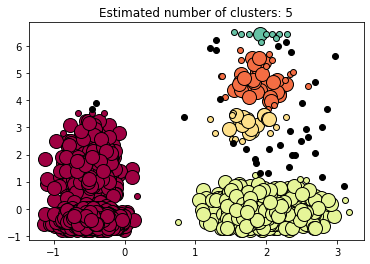

In [80]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [98]:
###HAC

%matplotlib inline

df=np.genfromtxt('driver_data.csv',delimiter=',',skip_header=1)

In [99]:
df

array([[ 71.24,  28.  ],
       [ 52.53,  25.  ],
       [ 64.54,  27.  ],
       ...,
       [170.91,  12.  ],
       [176.14,   5.  ],
       [168.03,   9.  ]])

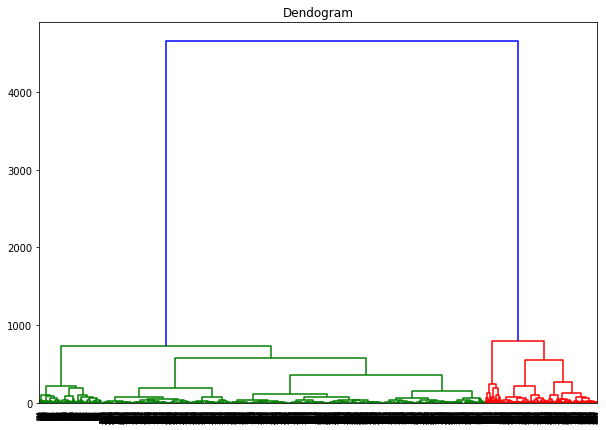

In [100]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10,7))
plt.title('Dendogram')
dend=shc.dendrogram(shc.linkage(df,method='ward'))



In [101]:
from sklearn.cluster import AgglomerativeClustering
cluster=AgglomerativeClustering(n_clusters=4,affinity='euclidean',linkage='ward')
cluster.fit_predict(df)

array([3, 3, 3, ..., 1, 1, 1], dtype=int64)

In [102]:
AgglomerativeClustering?

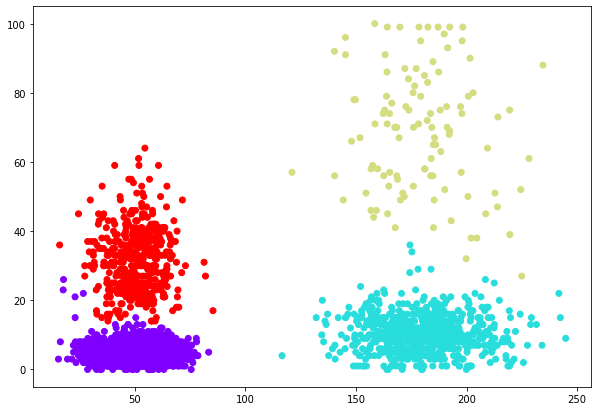

In [103]:
plt.figure(figsize=(10, 7))  
plt.scatter(df[:,0], df[:,1], c=cluster.labels_, cmap='rainbow')

####GMMM
Gaussian mixture models are a probabilistic model for representing normally distributed subpopulations within an overall population. Mixture models in general don't require knowing which subpopulation a data point belongs to, allowing the model to learn the subpopulations automatically. Since subpopulation assignment is not known, this constitutes a form of unsupervised learning.

For example, in modeling human height data, height is typically modeled as a normal distribution for each gender with a mean of approximately 5'10" for males and 5'5" for females. Given only the height data and not the gender assignments for each data point, the distribution of all heights would follow the sum of two scaled (different variance) and shifted (different mean) normal distributions. A model making this assumption is an example of a Gaussian mixture model (GMM), though in general a GMM may have more than two components. Estimating the parameters of the individual normal distribution components is a canonical problem in modeling data with GMMs.

GMMs have been used for feature extraction from speech data, and have also been used extensively in object tracking of multiple objects, where the number of mixture components and their means predict object locations at each frame in a video sequence.

In [18]:
df=np.genfromtxt('driver_data.csv',delimiter=',',skip_header=1)

In [19]:
df

array([[ 71.24,  28.  ],
       [ 52.53,  25.  ],
       [ 64.54,  27.  ],
       ...,
       [170.91,  12.  ],
       [176.14,   5.  ],
       [168.03,   9.  ]])

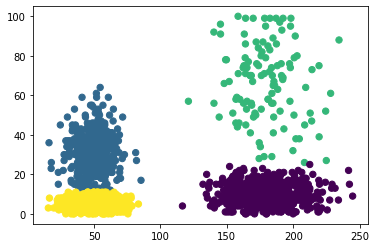

In [24]:
from sklearn.mixture import GaussianMixture as GMM
gmm=GMM(n_components=4).fit(df)
labels=gmm.predict(df)
plt.scatter(df[:,0],df[:,1],c=labels,s=40,cmap='viridis');

In [25]:
probs=gmm.predict_proba(df)
print(probs[:5].round(3))

[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


In [38]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import warnings

In [39]:
def plot_gmm(gmm, df, label=True, ax=None):
    ax = plt.gca()
    labels = gmm.fit(df).predict(df)
    if label:
        ax.scatter(df[:, 0], df[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(df[:, 0], df[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

In [40]:
rng = np.random.RandomState(13)
X_stretched = np.dot(df, rng.randn(2, 2))

NameError: name 'draw_ellipse' is not defined

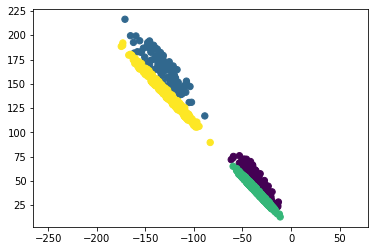

In [41]:
gmm = GMM(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

In [42]:
###GMM 
from sklearn.datasets import load_digits
digits=load_digits()
digits.data.shape




(1797, 64)

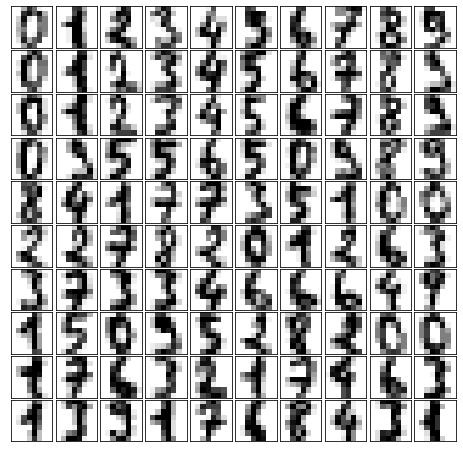

In [46]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

In [47]:
from sklearn.decomposition import PCA
pca=PCA(.99,whiten=True)
data=pca.fit_transform(digits.data)
data.shape

(1797, 41)

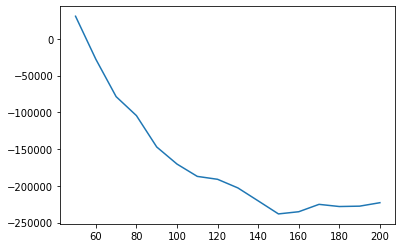

In [50]:
n_components=np.arange(50,210,10)
models=[GMM(n,covariance_type='full',random_state=0)
       for n in n_components]
aics=[model.fit(data).aic(data)for model in models]
plt.plot(n_components,aics);

In [51]:
gmm = GMM(100, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


In [52]:
data_new = gmm.sample(n_samples=100)
data_new

(array([[ 1.67014549, -0.15864571, -0.84833636, ...,  2.02785979,
         -1.22870034, -1.47350157],
        [-0.69720904, -0.73923104,  2.47131247, ...,  0.65805029,
         -0.94727818, -1.57044688],
        [-0.51613326, -0.24053276,  1.35748031, ..., -0.57291687,
          0.26839537, -2.36868612],
        ...,
        [-0.45057659, -0.80755738,  1.24227834, ...,  0.70727065,
         -1.82786348,  0.97816021],
        [-0.04354488, -0.7121553 ,  0.31584574, ...,  0.166123  ,
          0.51876568,  0.32271913],
        [-0.41610954, -1.41303141, -0.07013293, ...,  0.61790567,
         -0.19485302,  0.08491159]]),
 array([ 1,  2,  2,  3,  3,  4,  4,  5,  6,  7,  7,  8,  8,  8,  9, 10, 10,
        11, 12, 13, 13, 13, 17, 18, 18, 19, 19, 20, 20, 20, 20, 21, 22, 23,
        23, 25, 26, 27, 28, 31, 31, 33, 33, 35, 36, 37, 38, 38, 39, 39, 40,
        42, 44, 44, 45, 50, 52, 52, 52, 52, 52, 59, 62, 62, 65, 66, 68, 68,
        70, 70, 71, 71, 72, 72, 72, 72, 81, 83, 83, 84, 85, 86, 86, 8

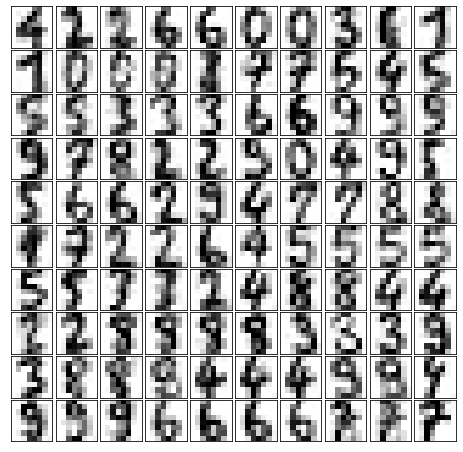

In [53]:
digits_new = pca.inverse_transform(data_new[0])
plot_digits(digits_new)

In [55]:
#####image segmentation using gmm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

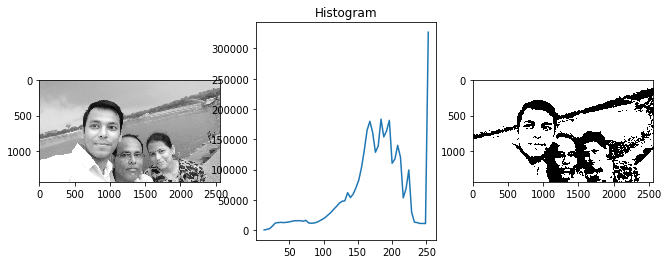

In [64]:
img=plt.imread('IMG_20170720_171057.jpg')[:,:,0]
hist,bin_edges=np.histogram(img,bins=60)
bin_centers=.5*(bin_edges[:-1]+bin_edges[1:])
classif=GaussianMixture(n_components=2)
classif.fit(img.reshape((img.size,1)))
threshold=np.mean(classif.means_)
binary_img=img>threshold
plt.figure(figsize=(11,4))
plt.subplot(131)
plt.imshow(img,'gray')
plt.subplot(132)
plt.title('Histogram')
plt.plot(bin_centers,hist)
plt.subplot(133)
plt.imshow(binary_img,cmap=plt.cm.gray,interpolation='nearest')
plt.show()

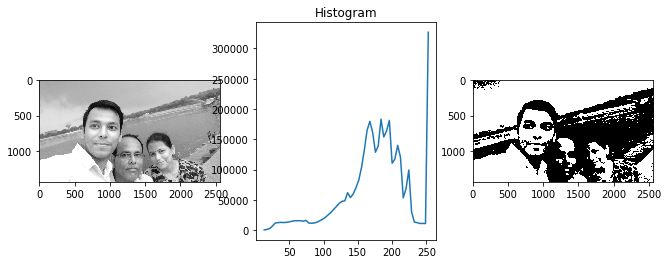

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

img = plt.imread("IMG_20170720_171057.jpg")[:,:,0] # Taking a single channel

hist, bin_edges = np.histogram(img, bins=60)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])

classif = GaussianMixture(n_components=4)
classif.fit(img.reshape((img.size, 1)))  # converting image to vector

threshold = np.mean(classif.means_)
binary_img = img > threshold


plt.figure(figsize=(11,4))

plt.subplot(131)
plt.imshow(img,'gray')
plt.subplot(132)
plt.title("Histogram")
plt.plot(bin_centers, hist)
plt.subplot(133)
plt.imshow(binary_img, cmap=plt.cm.gray, interpolation='nearest')
plt.show()